In [90]:
# importing necessary librarys
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import math

# Task:
* Choose >8 variables, where >=2 are numerical and >=2 are categorical, that correlate to the target variable in question ('SalePrice').
    * For each variabe:
        * Describe how it can affect the sales price
        * What its type is (numerical/categorical)
        * Make a data quality report
            * Continuous var.:
                1) Count - amount of total observations
                2) % missing - percent of N/A observations
                3) Cardinality - number of unique observations
                4) Min value - lowest observation
                5) Q1 (first quartile value) - in an ordered set of observations, the value at that separates the first 25% of data from the rest.
                6) Mean - the average of all observations.
                7) Median - in an ordered set of observations, the value in the middle.
                8) Q3 (third quartile value) - same as Q1 but at the 75% mark.
                9) Max - highest observation
                10) Standard deviation - statistic that tells us how the data is dispersed around the middle
                    * By calculating the standard deviation, we know the range of the values that surround the median.
                    * e.g. with 1 std. dev. we can estimate ~68 percent of values simply by subtracting or adding from to the median a value that is within the range bound by a negative and positive std. dev.
            * Categorical var.:
                1) Count - amount of total observations
                2) % missing - percent of N/A observations
                3) Cardinality - number of unique observations
                4) Mode - the most frequent value
                5) Mode frequency - amount of times the mode appears
                6) Mode % - percent of the observations that are the value of the mode
                7) 2nd Mode - value of the 2nd largest mode
                8) 2nd Mode % - percent of values the 2nd largest mode takes up in the observations
            * *Program calculations of **mathematical** values by hand*
        * Draw Histogram/Bar chart
        * Draw a boxplot
    * Draw >=3 scatterplots for chosen variables
* Realize a KNN

In [91]:
df = pd.read_csv("data/test.csv",sep=",")
my_col = ['SalePrice', 'LotArea', 'Condition1', 'OverallQual', 'OverallCond',
          'YearBuilt', 'YearRemodAdd', 'CentralAir', 'ExterCond'] 
for col in my_col:
    print(col, '\n', df[col].unique())


SalePrice 
 [206000  82000  86000 232000 136905 181000 149900 163500  88000 240000
 102000 135000 100000 165000  85000 119200 227000 203000 187500 160000
 213490 176000 194000  87000 191000 287000 112500 167500 293077 105000
 118000 197000 310000 230000 119750  84000 315500  97000  80000 155000
 173000 196000 262280 278000 139600 556581 145000 115000  84900 176485
 200141 144500 255000 180000 185850 248000 335000 220000 213500  81000
  90000 110500 154000 328000 178000 167900 151400  91500 159500 219500
 170000 138800 155900 126000 133000 192000 147000  83500 252000 137500
  92900 136500 146000 129000 176432 127000 128000 157000  60000 119500
 106000 325000 179900 274725 280000 188000 205000 129900 134500 117000
 318000 184100 130000 140000 133700 118400 212900 112000 163900 174000
 259000 215000  93500 117500 239500 169000 119000  94000 144000 139000
 197500 424870 149000 174500 116900 143000 124000 120500 201800 218000
 235128 185000 224000 108959 233170 245350 235000 625000 171000 1

# Variables chosen:

1) SalePrice - the property's sale price in dollars. 
    - Reason - ***Target variable to predict***
    - Type - Numerical discrete(dtype: float64) 

2) LotArea - Lot size in square feet
    - Reason - bigger the lot (land) size, bigger the value
    - Type - Numerical discrete (dtype: float64) 

3) Condition1 - Proximity to main road or railroad
    - Reason - if access to a main road is good or even greater, there is more appeal to people who would need to commute for work.
    - Type - Categorical nominal (could be seen as ordinal) (dtype: object) 

4) OverallQual - Overall material and finish quality
    - Reason - a house considered to be of better quality has more appeal then one with a worse quality.
    - Type - Numerical continuous (dtype: float64)

5) OverallCond - Overall condition rating
    - Reason - same reason as OverallQual, though this seems to mean something different.
    - Type - Numerical continuous (dtype: float64) 

6) YearBuilt - Original construction date
    - Reason - the newer the build of a house, the more "reliable" and modern it may seem.
        - Might have an adverse effect where antique houses can drive up the price.
    - Type - Numerical continuous (dtype: float64) 

7) YearRemodAdd - Remodel date
    - Reason - remodeled houses can have more appeal as there is no need for renowation.
    - Type - Numerical continuous (dtype: float64)

8) CentralAir - Central air conditioning
    - Reason - air conditioning is very prevalent in America, thus many people rely on it. If it is not present, there shouldn't be that much appeal, though I think this will mostly apply for cheaper houses.
    - Type - Categorical ordinal (in my opinion) (dtype: float64) 
        - A boolean 'Yes' or 'No' Value

9) ExterCond - Present condition of the material on the exterior
    - Reason - if the quality of the exterior is great, no urgent upkeep is needed in addition to the house being presented as of higher overall quality.
    - Type - Categorical ordinal (dtype: float64) 

In [92]:
t_cont = { # Data quality table for continuous variables
    'Feature' : ['SalePrice', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd'],
    'Count' :[],
    '% Miss':[],
    'Card.':[],
    'Min':[],
    'Q1':[],
    'Mean':[],
    'Median':[],
    'Q3':[],
    'Max':[],
    'Std. Dev.':[]
}
t_cate = { # Data quality table for categorical variables
    'Feature' : ['Condition1', 'CentralAir', 'ExterCond'],
    'Count' : [],
    '% Miss' : [],
    'Card.' : [],
    'Mode' : [],
    'Mode freq.' : [],
    'Mode %' : [],
    '2nd Mode' : [],
    '2nd Mode freq.' : [],
    '2nd Mode %' : []
}

# Implemented my own calculations for clarity/experience
def get_report_cont(feature:str, t_cont):
    obs_raw = df[feature]
    obs = obs_raw.sort_values().reset_index(drop=True)
    count = obs.count()

    # Count
    t_cont['Count'].append(count)

    # Miss %
    miss = (sum(obs.isna()) / len(obs)) *100
    t_cont['% Miss'].append(miss)

    # Cardinality
    card = len(obs.unique())
    t_cont['Card.'].append(card)

    # Min
    min = obs.min()
    t_cont['Min'].append(min)

    # Q1
    q1_i = count // 4 # get index
    q1 = obs[q1_i]
    q1_pd = obs.quantile(0.25, 'lower')
    if q1 == q1_pd: # check if correct
        t_cont['Q1'].append(q1)
    else:
        t_cont['Q1'].append('error')
        print(feature, " | Q1: ", q1, ' != ', q1_pd)

    # Mean
    obs_sum = 0
    for x in obs:
        obs_sum+=x
    mean = obs_sum / count
    if mean == obs.mean(): # check if correct
        t_cont['Mean'].append(mean)
    else:
        t_cont['Mean'].append('error')
        print(feature, " | Mean: ", mean, ' != ', obs.mean())

    # Median
    med_i = count // 2 # get index
    if count % 2 == 1:
        median = obs[med_i]
    else:
        median = (obs[med_i] + obs[med_i]) / 2

    median_pd = obs.quantile(0.5, 'midpoint')

    if median == median_pd: # check if correct
        t_cont['Median'].append(median)
    else:
        t_cont['Median'].append('error')
        print(feature, " | Median: ", median, ' != ', median_pd)

    # Q3
    q3_i = 3*(count//4) # get index
    q3 = obs[q3_i]

    q3_pd = obs.quantile(0.75, 'lower')

    if q3 == q3_pd: # check if correct
        t_cont['Q3'].append(q3)
    else:
        t_cont['Q3'].append('error')
        print(feature, " | Q3: ", q3, ' != ', q3_pd)
    
    # Max
    max = obs.max()
    t_cont['Max'].append(max)

    # Standard deviation
    x_sum = 0
    for x in obs:
        x_sum += (x-mean)**2
    std_dev = math.sqrt(x_sum/(obs.count()-1))
    
    if math.isclose(std_dev, obs.std(), rel_tol=1e-5):
        t_cont['Std. Dev.'].append(std_dev)
    else:
        t_cont['Std. Dev.'].append('error')
        print(feature, " | Std. Dev.: ", std_dev, ' != ', obs.std())

def get_report_cate(feature:str, t_cate):
    obs = df[feature]
    count = obs.count()

    value_counts = obs.value_counts() # gives array with modes and their frequencies
    mode_names = value_counts.index.tolist() # names of the modes
    mode_counts = value_counts.values # frequencies of the nodes

    t_cate['Count'].append(count)
    t_cate['% Miss'].append((sum(obs.isna()) / count) *100)
    t_cate['Card.'].append(len(obs.unique()))
    t_cate['Mode'].append(mode_names[0])
    t_cate['Mode freq.'].append(mode_counts[0])
    t_cate['Mode %'].append(mode_counts[0]/count*100)
    t_cate['2nd Mode'].append(mode_names[1])
    t_cate['2nd Mode freq.'].append(mode_counts[1])
    t_cate['2nd Mode %'].append(mode_counts[1]/count*100)

for feat in t_cont['Feature']:
    get_report_cont(feat, t_cont)

for feat in t_cate['Feature']:
    get_report_cate(feat, t_cate)

cont_df = pd.DataFrame(data=t_cont)
cate_df = pd.DataFrame(data=t_cate)
cont_df

,Feature,Count,% Miss,Card.,Min,Q1,Mean,Median,Q3,Max,Std. Dev.
0,SalePrice,461,0.0,297,52500,129000,178018.427332,162000,206900,745000,77495.649811
1,LotArea,461,0.0,392,1477,7500,10130.488069,9503,11500,63887,5738.877250
2,OverallQual,461,0.0,9,2,5,6.045553,6,7,10,1.381590
3,OverallCond,461,0.0,7,3,5,5.548807,5,6,9,1.121094
4,YearBuilt,461,0.0,98,1872,1950,1970.550976,1971,2000,2009,30.651692
5,YearRemodAdd,461,0.0,58,1950,1966,1984.015184,1992,2004,2009,21.139850


In [93]:
cate_df

,Feature,Count,% Miss,Card.,Mode,Mode freq.,Mode %,2nd Mode,2nd Mode freq.,2nd Mode %
0,Condition1,461,0.0,8,Norm,399,86.550976,Feedr,27,5.856833
1,CentralAir,461,0.0,2,Y,434,94.143167,N,27,5.856833
2,ExterCond,461,0.0,4,TA,411,89.154013,Gd,43,9.327549


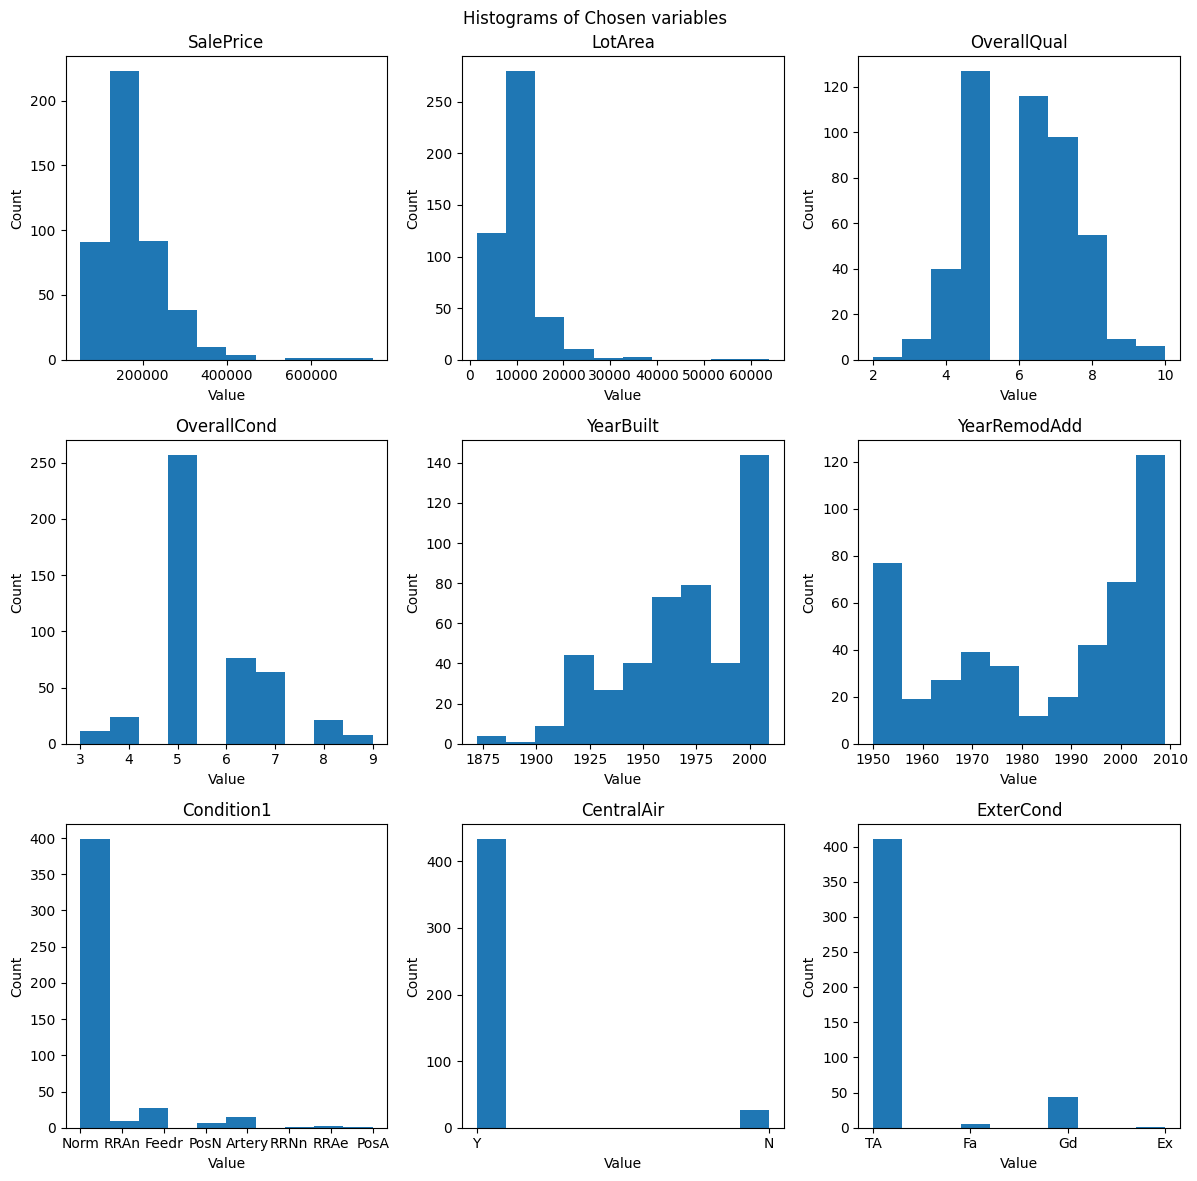

In [94]:
fig, axes = plt.subplots(3, 3, figsize=(12,12))

fig.suptitle("Histograms of Chosen variables")

all_feat = []
for f in t_cont['Feature']:
    all_feat.append(f)
for f in t_cate['Feature']:
    all_feat.append(f)

for feat, ax in zip(all_feat, axes.flatten()):
    ax.hist(df[feat])
    ax.set_xlabel('Value')
    ax.set_ylabel('Count')
    ax.set_title(feat)

plt.tight_layout()
plt.show()

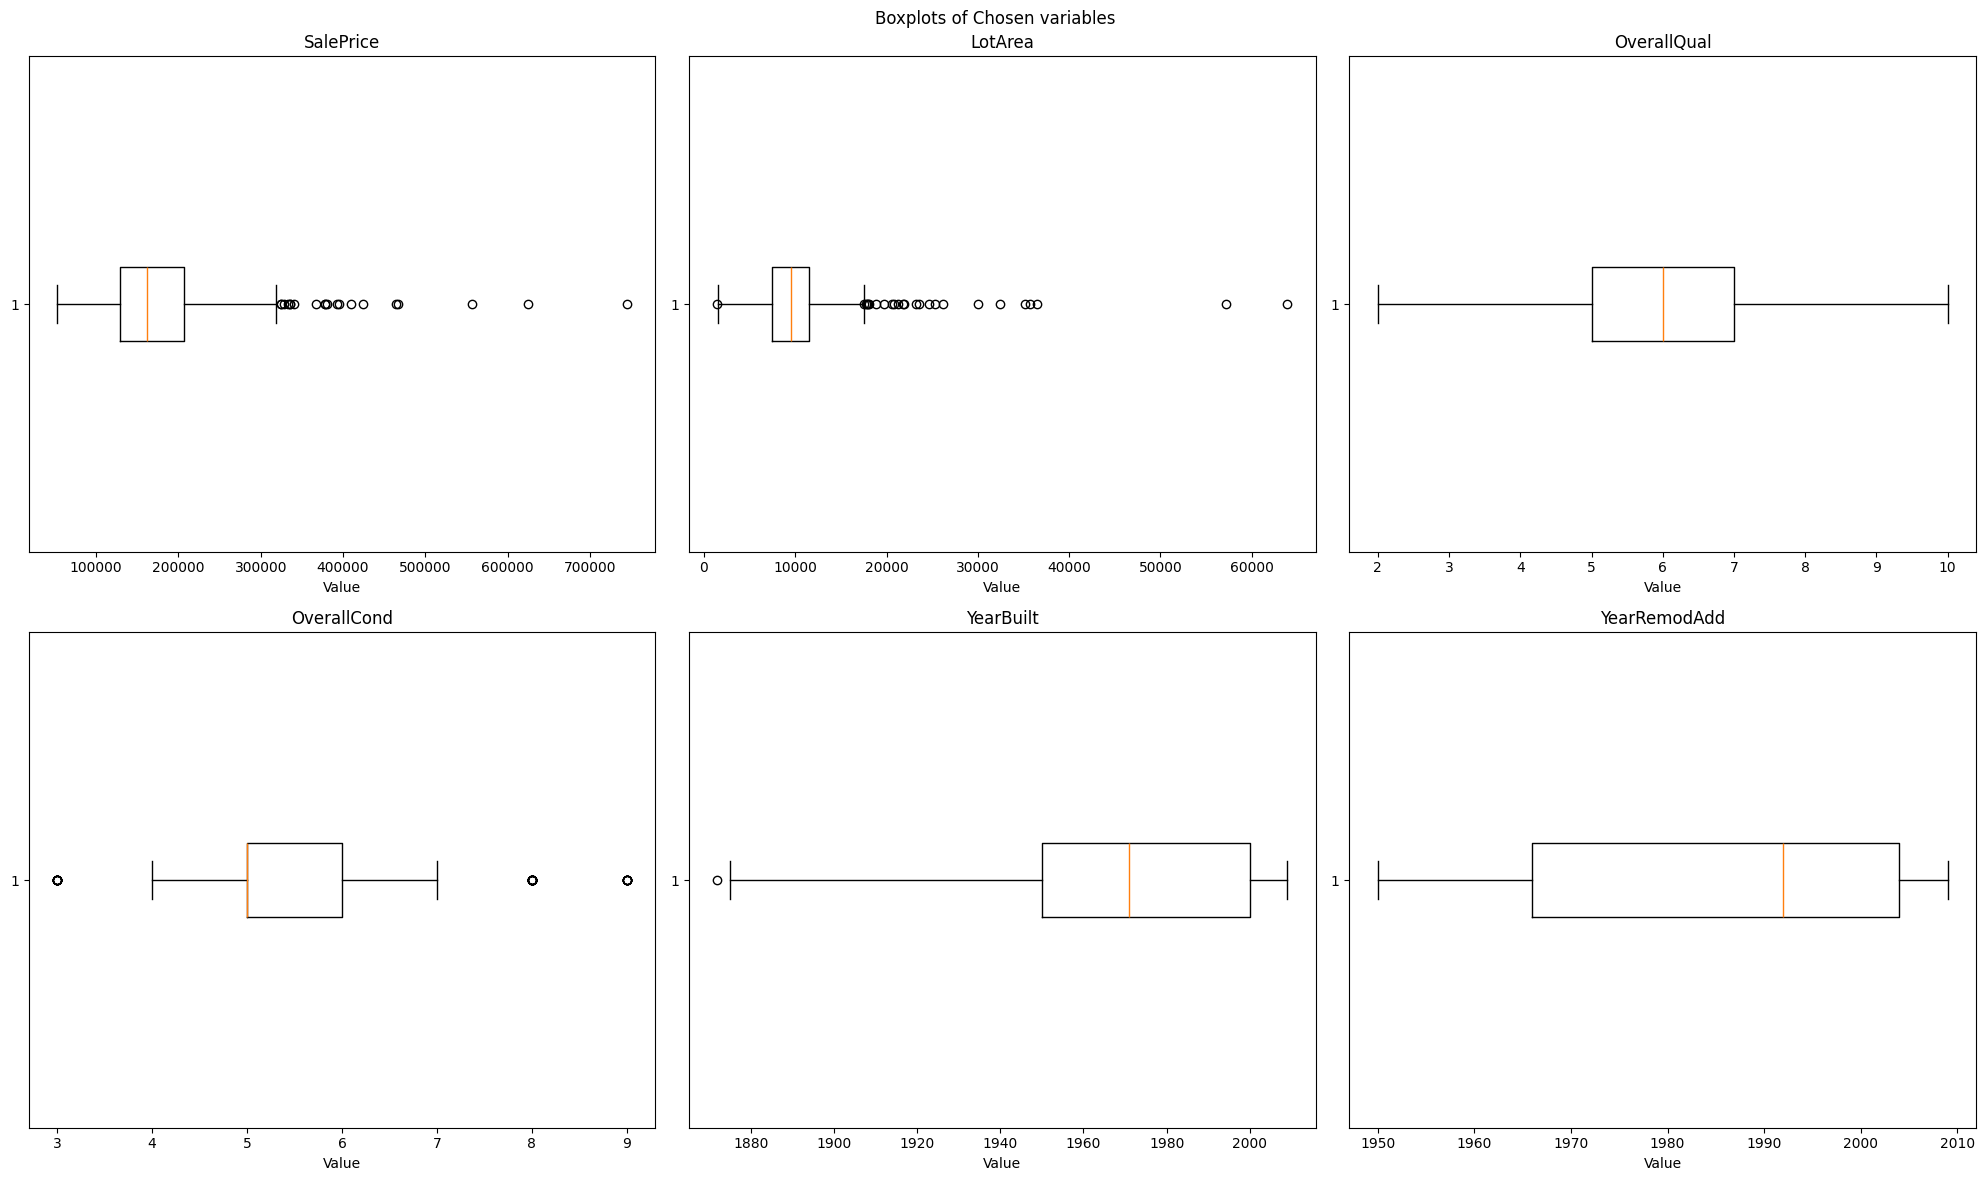

In [96]:
fig2, axes2 = plt.subplots(2, 3, figsize=(20,12))

fig2.suptitle("Boxplots of Chosen variables")

for feat, ax in zip(t_cont['Feature'], axes2.flatten()):
    ax.boxplot(df[feat], orientation='horizontal')
    ax.set_xlabel('Value')
    ax.set_title(feat)

plt.tight_layout()
plt.show()